# MNIST Digit Classifier

In [1]:
# This cell assumes a project structure of: project-root/src/experiments/this_notebook.ipynb
# We append the parent directory to the system path, so now we can import modules from src
# We also create a variable named path which points to the project root.

import sys
from pathlib import Path

sys.path.append("../") # go to parent dir
path =  str(Path().resolve().parent.parent)

print(path)


/workspaces/Kaggle-Knowledge-Competitions


When using JAX in notebooks, it's nice to disable GPU memory preallocation

In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


Class of configurations (consider using Hydra for heavier workloads in future):

In [6]:
from dataclasses import dataclass, asdict

@dataclass
class Configurations:
    data_dir: str = path + "/data/kaggle_mnist"
    batch_size: int = 64
    num_workers: int = 0
    pin_memory: bool = False
    drop_last: bool = True

    lr: float = 0.01
    momentum: float = 0.9

    num_epochs: int = 5

    log_dir: str = path + "/logs/flax-digit-classifier"
    log_every_n_steps: int = 50

cfg = Configurations()

In [7]:
import os
import jax
from torch.utils.data import random_split
import torch

from datasets.kaggle_mnist import KaggleMNIST, NumpyLoader

data = KaggleMNIST(data_dir=cfg.data_dir, train=True, transform=None)

g = torch.Generator()
g.manual_seed(0)

n_val = int(len(data) * 0.2)
n_train = len(data) - n_val
train_data, val_data = random_split(data, [n_train, n_val], generator=g)

train_loader = NumpyLoader(
    train_data,
    shuffle=True,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    drop_last=cfg.drop_last,
)

val_loader = NumpyLoader(
    val_data,
    shuffle=False,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    drop_last=cfg.drop_last,
)

batch = next(iter(train_loader))
batch_imgs, batch_labels = batch
batch_imgs.shape


(64, 28, 28, 1)

In [8]:
from trainer.digit_classifier_trainer import train_digit_classifier
from models.digit_classifier import ResNet18
import optax
from clu import metric_writers
import socket
from datetime import datetime

model = ResNet18(num_classes=10)
optimizer = optax.sgd(cfg.lr, cfg.momentum)

current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join(
                cfg.log_dir, current_time + '_' + socket.gethostname())

logger = metric_writers.create_default_writer(log_dir, )

trained_state = train_digit_classifier(
    42,
    model,
    train_loader,
    val_loader,
    num_epochs=cfg.num_epochs,
    optimizer=optimizer,
    logger=logger,
    log_every_n_steps=cfg.log_every_n_steps,
)

Epoch 4, val: 100%|██████████| 131/131 [00:00<00:00, 346.69it/s]


In [ ]:
from trainer.digit_classifier_trainer import test_digit_classifier

data = KaggleMNIST(data_dir=cfg.data_dir, train=False, transform=None)
test_loader = NumpyLoader(
    data,
    shuffle=False,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
)

imgs, preds = test_digit_classifier(trained_state, test_loader)

Generating Predictions on Test Set: 100%|██████████| 438/438 [00:02<00:00, 214.79it/s]


7
5
1
5
8
0
1
6
6
8


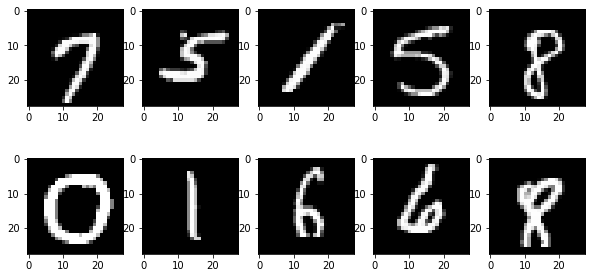

In [ ]:
import matplotlib.pyplot as plt
import random

imgs = imgs.squeeze()

nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,5))

for i in range(nrows):
    for j in range(ncols):
        k = random.randint(0,28000)
        axs[i,j].imshow(imgs[k],cmap="gray")
        print(preds[k])

Finally, save our predictions in the format for Kaggle submission. You can submit by running the following line:
```bash
# submits preds.csv to the mnist classification competition
kaggle competitions submit -c digit-recognizer -f data/kaggle_mnist/preds.csv --message first_submission_with_api
```

In [ ]:
import pandas as pd
df = pd.DataFrame({"ImageId" : list(range(1, 28001)),"Label" : preds})
df.to_csv(path+"/data/kaggle_mnist/preds.csv", index=False)